In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

from hep_ml import metrics
from utils import check_correlation
from mass_correlation_utils import *

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Loading
`training.csv` is a mixture of simulated signal, real background.

In [2]:
train_df = pd.read_csv('Data/training.csv.gz', sep=',')

In [3]:
train_df.head()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


In [4]:
train_df.columns

Index(['id', 'LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits', 'production',
       'signal', 'mass', 'min_ANNmuon'],
      dtype='object')

In [28]:
train_df.shape

(67553, 51)

In [5]:
test_df = pd.read_csv('Data/test.csv.gz', sep=',', index_col='id')

In [6]:
test_df.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits
id,,,,,,,,,,,,,,,,,,,,,
14711831,0.001273,0.999816,8.569642,0.310039,0.197893,5.183939,2.286117,687.479248,0.022301,0.050763,...,508.926514,306.629456,714.222717,30300.734375,5662.158691,7406.368164,4.779700,3.608334,3.029715,705
16316387,0.000661,0.999954,7.061379,0.348772,0.067430,6.316281,3.865824,5691.845703,0.002455,0.037633,...,943.130676,3287.291260,1563.593994,6160.323730,43781.566406,19728.500000,2.563915,3.280884,3.226650,907
6771382,0.000889,0.999999,6.502967,0.273914,0.011020,0.865816,1.004631,5429.225586,0.002753,0.036379,...,2886.055908,2216.936279,598.068359,26387.134766,15534.978516,6504.145020,2.903129,2.634985,3.077517,213
686045,0.001295,0.999301,7.838184,0.325697,0.388636,11.391245,10.345356,661.717834,0.008163,0.436003,...,461.727753,357.967560,1118.084229,5451.857422,10281.403320,23722.742188,3.160085,4.050494,3.747409,275
8755882,0.001714,0.999805,7.064559,0.113440,0.154421,13.925871,12.951378,3885.417969,0.066317,0.052183,...,1773.747925,1643.278198,711.572205,7724.954590,12830.546875,6008.145996,2.151059,2.744157,2.823017,357


In [7]:
test_df.columns

Index(['LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits'],
      dtype='object')

In [29]:
test_df.shape

(855819, 46)

# Baseline Model

In [8]:
train, valid = train_test_split(train_df, test_size=0.3, random_state=13)

Feature selction for training.

In [9]:
variables = list(set(train_df.columns) - {'id', 'signal', 'mass', 'production', 'min_ANNmuon'})
print(variables)

['CDF3', 'DOCAtwo', 'DOCAthree', 'p0_IsoBDT', 'p2_IPSig', 'p0_IP', 'p2_IsoBDT', 'iso', 'p2_track_Chi2Dof', 'p0_pt', 'isolationd', 'p0_track_Chi2Dof', 'p2_pt', 'p0_eta', 'p1_p', 'p1_eta', 'isolatione', 'CDF1', 'LifeTime', 'pt', 'CDF2', 'FlightDistanceError', 'VertexChi2', 'p1_IP', 'p0_p', 'p1_pt', 'IP', 'isolationb', 'isolationa', 'p1_IsoBDT', 'IPSig', 'p2_eta', 'ISO_SumBDT', 'isolationf', 'p1_track_Chi2Dof', 'p2_IP', 'p0_IPSig', 'dira', 'SPDhits', 'isolationc', 'IP_p0p2', 'IP_p1p2', 'DOCAone', 'FlightDistance', 'p1_IPSig', 'p2_p']


In [10]:
%%time
clf = AdaBoostClassifier(n_estimators=100, 
                         learning_rate=0.01, 
                         random_state=13,
                         base_estimator=DecisionTreeClassifier(max_depth=6, 
                                                               min_samples_leaf=30, 
                                                               max_features=6,
                                                               random_state=13))
clf.fit(train[variables], train['signal'])

Wall time: 27.6 s


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=13, splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=13)

## Model Assesment on Validation Set


In [11]:
def plot_metrics(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.plot(fpr, tpr, label='ROC AUC=%f' % roc_auc)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title("ROC Curve")

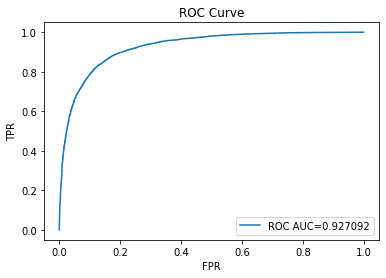

In [32]:
y_pred = clf.predict_proba(valid[variables])[:, 1]

assert valid.shape[0], y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

In [33]:
valid.shape

(20266, 51)

In [34]:
y_pred.shape

(20266,)

ROC AUC is just a part of the solution, we also have to make sure that

- The classifier output is not correlated with the mass
- Classifier performs similarily on MC and real data of the normalization channel

### 1. Mass Correlation Check

In [35]:
df_corr_check = pd.read_csv("Data/check_correlation.csv.gz")

In [39]:
df_corr_check.shape

(5514, 48)

In [42]:
y_pred = clf.predict(df_corr_check[variables])

In [45]:
eff = get_efficiencies(y_pred, 
                       df_corr_check.mass, 
                       thresholds=[0.5]) # thresholds=[0.2, 0.4, 0.5, 0.6, 0.8])

In [46]:
eff.keys()

odict_keys([0.5])

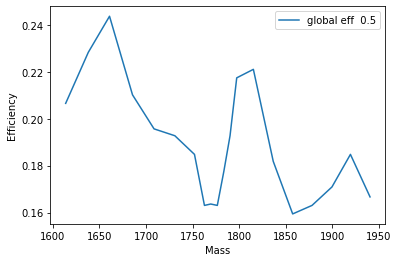

In [47]:
for label_name, eff_data in eff.items():
    plt.plot(eff_data[0], eff_data[1], label="global eff  %.1f" % label_name)

plt.xlabel('Mass')
plt.ylabel('Efficiency')
plt.legend();

In [48]:
corr_metric = check_correlation(y_pred, df_corr_check['mass'])
print(corr_metric)

0.00016658612015276115


### 2. Performace on Simulated Data (MC) vs Read Data

In [49]:
df_agreement = pd.read_csv('Data/check_agreement.csv.gz')

In [50]:
df_agreement.columns

Index(['id', 'LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits', 'signal',
       'weight'],
      dtype='object')

In [51]:
df_agreement[variables].head()

,CDF3,DOCAtwo,DOCAthree,p0_IsoBDT,p2_IPSig,p0_IP,p2_IsoBDT,iso,p2_track_Chi2Dof,p0_pt,...,p0_IPSig,dira,SPDhits,isolationc,IP_p0p2,IP_p1p2,DOCAone,FlightDistance,p1_IPSig,p2_p
0,0.179091,0.084005,0.066887,-0.019306,8.853514,0.483199,-0.098372,4.0,1.487057,1438.064697,...,24.701061,0.999964,512,1,0.185107,0.214719,0.082219,6.945030,10.732132,15195.594727
1,0.584701,0.044154,0.001321,-0.278330,7.737038,0.712242,-0.194944,3.0,1.336784,316.791351,...,11.312134,0.999818,552,17,0.039357,0.217507,0.007983,9.468235,16.435398,23134.953125
2,0.295038,0.106614,0.005850,-0.115879,44.521961,0.381544,-0.152291,1.0,0.798658,1887.477905,...,16.435801,0.999847,318,1,0.335788,0.885080,0.045085,13.280714,20.686119,10180.791016
3,0.533615,0.038642,0.003864,-0.208248,9.630725,0.564650,-0.434991,0.0,0.938619,975.041687,...,24.878387,0.999998,290,3,0.076522,0.068347,0.055115,5.166821,7.873435,24291.875000
4,0.926410,0.020872,0.014612,-0.328938,7.389726,0.373736,-0.344313,0.0,1.123868,6035.000977,...,28.557213,0.999896,45,0,0.249906,0.139937,0.015587,10.897236,18.738485,24241.628906


In [52]:
def splitted_ROC_curve(data_zero, data_one, sample_weights_zero, sample_weights_one):
    """
    Compute Roc Curve
    
    Input:
    - Data_zero: 0-labeled data
    - Data_one:  1-labeled data
    - Sample_weights_zero: weights for 0-labeled data
    - Sample_weights_one:  weights for 1-labeled data
    
    Output: 
    - roc curve
    """
    
    labels = [0] * len(data_zero) + [1] * len(data_one)
    weights = np.concatenate([sample_weights_zero, sample_weights_one])
    data_all = np.concatenate([data_zero, data_one])
    fpr, tpr, _ = roc_curve(labels, data_all, sample_weight=weights)
    return fpr, tpr

In [53]:
def compute_ks(data_prediction, mc_prediction, weights_data, weights_mc):
    """
    Compute Kolmogorov-Smirnov (ks) distance between real data predictions cdf and Monte Carlo one.
    Input:
    - data_prediction: Real data predictions
    - mc_prediction: Monte Carlo data predictions
    - weights_data: Real data weights
    - weights_mc: Monte Carlo weights
    
    Output
    - ks value
    """
    assert len(data_prediction) == len(weights_data), 'Data length and weight one must be the same'
    assert len(mc_prediction) == len(weights_mc), 'Data length and weight one must be the same'

    data_prediction, mc_prediction = np.array(data_prediction), np.array(mc_prediction)
    weights_data, weights_mc = np.array(weights_data), np.array(weights_mc)

    assert np.all(data_prediction >= 0.) and np.all(data_prediction <= 1.), 'Data predictions are out of range [0, 1]'
    assert np.all(mc_prediction >= 0.) and np.all(mc_prediction <= 1.), 'MC predictions are out of range [0, 1]'

    weights_data /= np.sum(weights_data)
    weights_mc /= np.sum(weights_mc)

    fpr, tpr = splitted_ROC_curve(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = np.max(np.abs(fpr - tpr))
    return Dnm

In [54]:
agreement_probs = clf.predict_proba(df_agreement[variables])[:, 1]

ks = compute_ks(
                agreement_probs[df_agreement['signal'].values == 0],
                agreement_probs[df_agreement['signal'].values == 1],
                df_agreement[df_agreement['signal'] == 0]['weight'].values,
                df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks)
print("KS Metric value is Fine:", ks < 0.09)

KS metric: 0.15888450993360032
KS Metric value is Fine: False


In [57]:
def plot_ks(X_agreement, y_pred):
    sig_ind = X_agreement[X_agreement['signal'] == 1].index
    bck_ind = X_agreement[X_agreement['signal'] == 0].index

    mc_prob = y_pred[sig_ind]
    mc_weight = np.array(X_agreement.loc[sig_ind]['weight'])
    
    data_prob = y_pred[bck_ind]
    data_weight = np.array(X_agreement.loc[bck_ind]['weight'])
    
    inds = data_weight < 0
    mc_weight = np.array(list(mc_weight) + list(-data_weight[inds]))
    mc_prob = np.array(list(mc_prob) + list(data_prob[inds]))
    
    data_prob = data_prob[data_weight >= 0]
    data_weight = data_weight[data_weight >= 0]
    
    plt.hist(data_prob, weights=data_weight, color='r', histtype='step', density=True, bins=60, label='Data')
    plt.hist(mc_prob, weights=mc_weight, color='b', histtype='step', density=True, bins=60, label='MC')
    
    plt.xlabel("Prediction")
    plt.legend()
    plt.show()

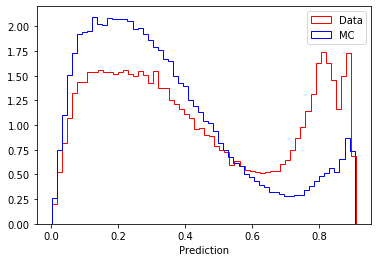

In [58]:
plot_ks(df_agreement, agreement_probs)

We can clearly see that that there is no agreemen between the simualted data and the real data.

## Solution 1: Add Random Noise

To increase the agreement between the real data and simualted data, we can add random noise in predicted probabilities.

In [59]:
def add_noise(array, level=0.40, random_seed=34, noise="uniform"):
    np.random.seed(random_seed)
    if noise == "uniform":
        return level * np.random.uniform(size=array.size) + (1 - level) * array
    elif noise == "gaussian":
        return level * np.random.normal(size=array.size) + (1 - level) * array
    elif noise == "laplacian":
        return level * np.random.laplace(size=array.size) + (1 - level) * array
    elif noise == "laplacian":  
        return level * np.random.standard_t(df=1, size=array.size) + (1 - level) * array

In [60]:
agreement_probs_noise = add_noise(clf.predict_proba(df_agreement[variables])[:, 1])

In [63]:
ks_noise = compute_ks(
                        agreement_probs_noise[df_agreement['signal'].values == 0],
                        agreement_probs_noise[df_agreement['signal'].values == 1],
                        df_agreement[df_agreement['signal'] == 0]['weight'].values,
                        df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks_noise)
print("KS Metric value is Fine:", ks_noise < 0.09)

KS metric: 0.03513613203320065
KS Metric value is Fine: True


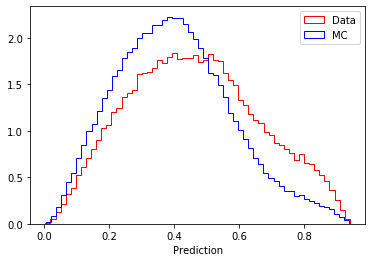

In [62]:
plot_ks(df_agreement, agreement_probs_noise)

### Effect on ROC

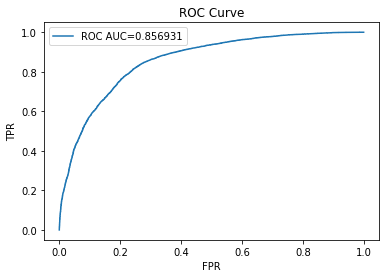

In [67]:
y_pred = add_noise(clf.predict_proba(valid[variables])[:, 1])

assert valid.shape[0] == y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

We have lost the accuracy of the model by adding noise.